In [36]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

from sklearn.linear_model import RidgeCV, LassoCV

from sklearn.model_selection import cross_val_score, KFold

from sklearn.utils import resample



In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [6]:
# cargo de datos

x_train = np.load('/content/drive/MyDrive/Colab Notebooks/2023-2S-AAD-1Corte/datos_validar/part2xTrain.npy')
x_val = np.load('/content/drive/MyDrive/Colab Notebooks/2023-2S-AAD-1Corte/datos_validar/part2xVal.npy')

y_train = np.load('/content/drive/MyDrive/Colab Notebooks/2023-2S-AAD-1Corte/datos_validar/part2yTrain.npy')
y_val = np.load('/content/drive/MyDrive/Colab Notebooks/2023-2S-AAD-1Corte/datos_validar/part2yVal.npy')

X = np.concatenate((x_train, x_val))
Y = np.concatenate((y_train, y_val))
X, X.shape,Y, Y.shape

(array([-2.13979053,  2.44720121, -2.47531695, -0.49506981, -1.76334267,
         1.08597516, -2.39292659, -1.40980993, -0.45666345,  2.05461486,
         1.45180619,  1.94814015,  0.83321629, -1.99010179, -2.39126567,
        -0.38338854, -2.22118293, -1.16068387,  0.57809041,  2.30997673,
         1.94602569,  1.58048754]),
 (22,),
 array([21.03982086, 59.43614993, 64.14865573,  2.93098205, -0.34083606,
        -6.0439709 , 45.85761295, -9.1155018 ,  4.76457773, 13.00965774,
        -6.20064498,  8.66061131, -2.05628737, 10.98695598, 49.97326063,
         0.83354263, 28.01794014, -8.87745452,  1.0039882 , 37.26325298,
         8.80237191, -6.35491001]),
 (22,))

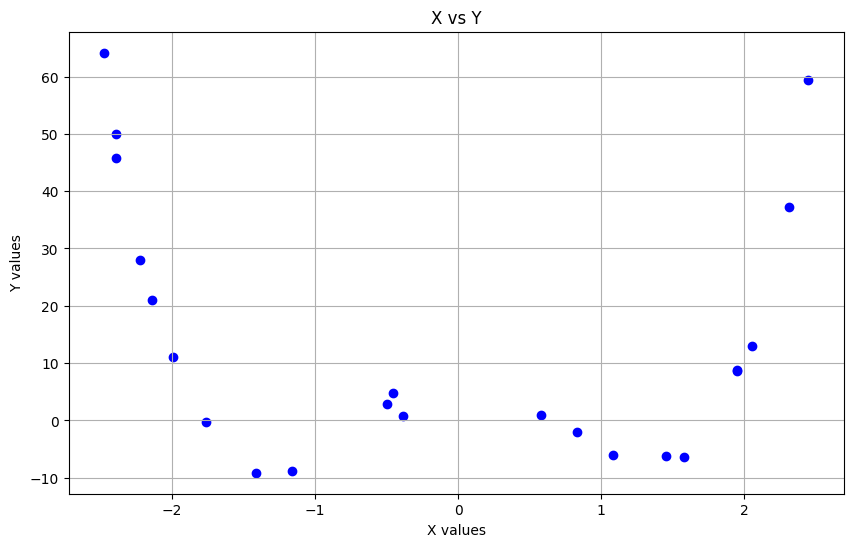

In [7]:

# Plotting X vs Y
plt.figure(figsize=(10, 6))
plt.scatter(X, Y, c='blue', marker='o')
plt.xlabel("X values")
plt.ylabel("Y values")
plt.title("X vs Y")
plt.grid(True)
plt.show()

Polinomio de Grado 1 AVG_MSE : 114253.15714640965 y var: 507.82336129819885
Polinomio de Grado 2 AVG_MSE : 12300.455377143475 y var: 173.14811999193748
Polinomio de Grado 3 AVG_MSE : 14861.621024635684 y var: 181.17330870224092
Polinomio de Grado 4 AVG_MSE : 4.811836332291998 y var: 4.83673809270488
Polinomio de Grado 5 AVG_MSE : 4.553747589780262 y var: 4.9065143812036


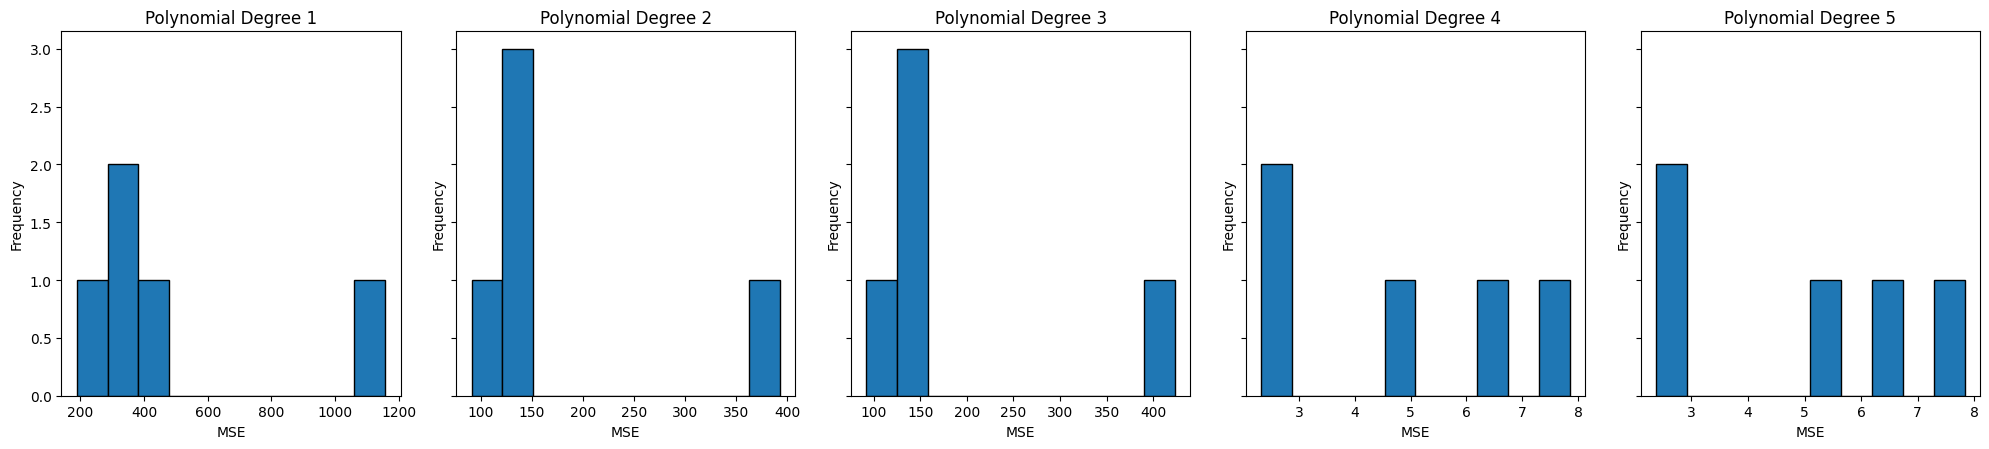

In [27]:
n_folds = 5
degrees = [1, 2, 3, 4, 5]
mse_scores = {}
average_mse = []
variance_mse = []

for degree in degrees:

    poly = PolynomialFeatures(degree=degree)

    X_poly = poly.fit_transform(X.reshape(-1, 1))

    model = LinearRegression()

    # cross-validation
    scores = cross_val_score(model, X_poly, Y, cv=n_folds, scoring='neg_mean_squared_error')

    # Convert negative MSE to positive
    scores = -scores

    # Save the MSE scores
    mse_scores[degree] = scores
    avg_mse = np.mean(scores)
    var_mse = np.var(scores)
    print(f'Polinomio de Grado {degree} AVG_MSE : {var_mse} y var: {avg_mse}')

    average_mse.append(avg_mse)
    variance_mse.append(var_mse)


fig, axes = plt.subplots(1, len(degrees), figsize=(20, 5), sharey=True)

for ax, degree in zip(axes, degrees):
    ax.hist(mse_scores[degree], bins=10, edgecolor='black')
    ax.set_title(f'Polynomial Degree {degree}')
    ax.set_xlabel('MSE')
    ax.set_ylabel('Frequency')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()



## Regularización

In [34]:
ridge_results = []
lasso_results = []

# rango de hiperparámetros lambda para Ridge y Lasso
lambdas = np.logspace(-6, 6, 13)

# Definir el esquema de validación cruzada
kf = KFold(n_splits=5, shuffle=True, random_state=42)

for degree in range(1, 5):

    poly = PolynomialFeatures(degree)
    X_poly = poly.fit_transform(X.reshape(-1, 1))

    # Ridge Regression con validación cruzada
    ridge = RidgeCV(alphas=lambdas, store_cv_values=True)
    ridge.fit(X_poly, Y)
    ridge_cv_mse = np.mean(ridge.cv_values_, axis=0)
    ridge_best_alpha = ridge.alpha_

    # Lasso Regression con validación cruzada
    lasso = LassoCV(alphas=lambdas, cv=kf)
    lasso.fit(X_poly, Y)
    lasso_best_alpha = lasso.alpha_
    lasso_mse = mean_squared_error(Y, lasso.predict(X_poly))

    ridge_results.append((degree, ridge_best_alpha, np.min(ridge_cv_mse)))
    lasso_results.append((degree, lasso_best_alpha, lasso_mse))

ridge_results, lasso_results


([(1, 1000000.0, 550.3613236879054),
  (2, 1.0, 206.70169033026204),
  (3, 10.0, 243.30840639528242),
  (4, 1e-06, 4.608942384495138)],
 [(1, 1000000.0, 501.46419459571075),
  (2, 0.1, 146.66957665732778),
  (3, 1.0, 146.89353315697582),
  (4, 1e-06, 2.488206269968732)])

## Boostrap

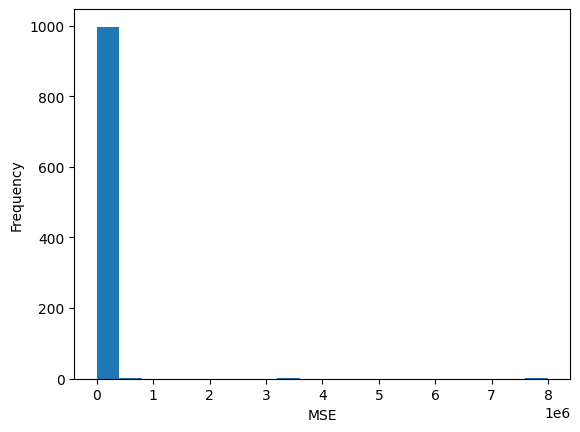

(11840.522012448202, 74844545186.88818)

In [42]:

n_iterations = 1000
n_size = int(len(X) * 0.5)
df = np.column_stack([X, Y])

# Run bootstrap
boot_mse = list()

poly = PolynomialFeatures(degree=4)

for i in range(n_iterations):

    # prepare train
    train = resample(df, n_samples=n_size)
    X_train, Y_train = train[:, 0], train[:, 1]

    test = np.array([x for x in df if x.tolist() not in train.tolist()])
    X_test, Y_test = test[:, 0], test[:, 1]

    X_train_poly = poly.fit_transform(X_train.reshape(-1, 1))
    X_test_poly = poly.transform(X_test.reshape(-1, 1))

    # fit model
    model = LinearRegression()
    model.fit(X_train_poly, Y_train)

    # evaluate model
    predictions = model.predict(X_test_poly)
    mse = mean_squared_error(Y_test, predictions)
    boot_mse.append(mse)

# plot scores
plt.hist(boot_mse, bins=20)
plt.xlabel('MSE')
plt.ylabel('Frequency')
plt.show()

# MSE point estimates
mean_mse = np.mean(boot_mse)
var_mse = np.var(boot_mse)

mean_mse, var_mse
